In [196]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import scipy.io as sio
import scipy.sparse as scisparse
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler

NT, NT0    = 60, 30
NX, NY, NZ = 160, 160, 5
DX, DY, DZ = 250, 250, 40
sec2year   = 365.25 * 24 * 60 * 60
psi2pascal = 6894.76
co2_rho    = 686.5266
mega       = 1e6
mt2m3      = sec2year*co2_rho/mega/1e3

***

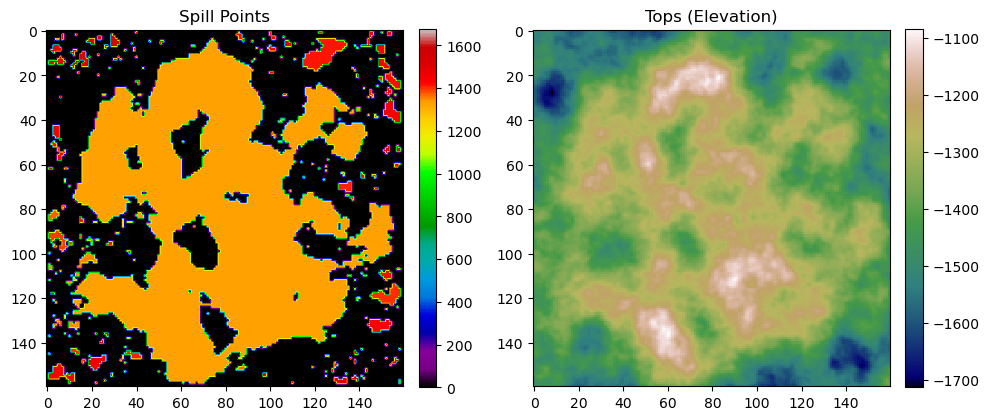

In [233]:
structuralTraps = sio.loadmat('structuralTraps.mat', simplify_cells=True)['ts']
grid = sio.loadmat('G.mat', simplify_cells=True)['G']
gridVE = sio.loadmat('Gt.mat', simplify_cells=True)['Gt']
tops2d = -gridVE['cells']['z'].reshape(NX,NY)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
im1 = axs[0].imshow(structuralTraps['z_spill_loc'].reshape(NX,NY), cmap='nipy_spectral')
im2 = axs[1].imshow(tops2d, cmap='gist_earth', interpolation='none')
[plt.colorbar(i, pad=0.04, fraction=0.046) for i in [im1, im2]]
[a.set(title=['Spill Points', 'Tops (Elevation)'][i]) for i,a in enumerate(axs)]
plt.tight_layout()
plt.show()

In [239]:
sample = 314
dd = sio.loadmat('states/states_{}.mat'.format(sample), simplify_cells=True)['var']
ww = sio.loadmat('well_locs/well_locs_{}.mat'.format(sample), simplify_cells=True)['var'] - 1
cc = sio.loadmat('controls/controls_{}.mat'.format(sample), simplify_cells=True)['var'] * sec2year * co2_rho / 1e3 / mega

rock = np.load('rock/VE2d/npz/rock2d_{}.npz'.format(sample))
perm = np.repeat(np.expand_dims(rock['perm'].reshape(NX,NY), -1), NT0, axis=-1)
poro = np.repeat(np.expand_dims(rock['poro'].reshape(NX,NY), -1), NT0, axis=-1)
rock.close()

pressure   = np.moveaxis(np.load('states/pressure/pressure_{}.npy'.format(sample)), 0, -1)
saturation = np.moveaxis(np.load('states/saturation/saturation_{}.npy'.format(sample)), 0, -1)

if len(cc.shape) == 1:
    cc = cc.reshape(1, -1)
if len(ww.shape) == 1:
    ww = ww.reshape(1, -1)

well_locs = np.zeros((NX,NY))
well_locs[ww[:,1], ww[:,0]] = 1
well_locs = np.repeat(np.expand_dims(well_locs, -1), NT0, axis=-1)

controls = np.zeros((NX,NY,NT0))
controls[ww[:,1], ww[:,0], :] = cc

tops = np.repeat(np.expand_dims(tops2d, -1), NT0, axis=-1)

features = np.stack([poro, perm, tops, well_locs, controls], axis=0)
labels = np.stack([pressure, saturation], axis=0)

print(dd[-1].keys())
print('poro:  {} | perm: {} | tops: {}'.format(poro.shape, perm.shape, tops.shape))
print('wells: {} | controls: {}'.format(well_locs.shape, controls.shape))
print('pressure: {} | saturation: {}'.format(pressure.shape, saturation.shape))
print('-')
print('features: {} | labels: {}'.format(features.shape, labels.shape))

dict_keys(['pressure', 's', 's3d', 't', 'dT', 'wellSol', 'totVol', 'vol', 'freeVol', 'trappedVol', 'leakedVol'])
poro:  (160, 160, 30) | perm: (160, 160, 30) | tops: (160, 160, 30)
wells: (160, 160, 30) | controls: (160, 160, 30)
pressure: (160, 160, 60) | saturation: (160, 160, 60)
-
features: (5, 160, 160, 30) | labels: (2, 160, 160, 60)


In [247]:
def process_data(i):
    tops = np.repeat(np.expand_dims(tops2d, -1), NT0, axis=-1)
    rock = np.load('rock/VE2d/npz/rock2d_{}.npz'.format(i))
    perm = np.repeat(np.expand_dims(rock['perm'].reshape(NX,NY), -1), NT0, axis=-1)
    poro = np.repeat(np.expand_dims(rock['poro'].reshape(NX,NY), -1), NT0, axis=-1)
    rock.close()

    pressure   = np.moveaxis(np.load('states/pressure/pressure_{}.npy'.format(i)), 0, -1)
    saturation = np.moveaxis(np.load('states/saturation/saturation_{}.npy'.format(i)), 0, -1)

    ww = sio.loadmat('well_locs/well_locs_{}.mat'.format(i), simplify_cells=True)['var'] - 1
    cc = sio.loadmat('controls/controls_{}.mat'.format(i), simplify_cells=True)['var'] * sec2year * co2_rho / 1e3 / mega

    if len(cc.shape) == 1:
        cc = cc.reshape(1, -1)
    if len(ww.shape) == 1:
        ww = ww.reshape(1, -1)

    well_locs = np.zeros((NX,NY))
    well_locs[ww[:,1], ww[:,0]] = 1
    well_locs = np.repeat(np.expand_dims(well_locs, -1), NT0, axis=-1)

    controls = np.zeros((NX,NY,NT0))
    controls[ww[:,1], ww[:,0], :] = cc

    features = np.stack([poro, perm, tops, well_locs, controls], axis=0)
    labels = np.stack([pressure, saturation], axis=0)

    np.savez('data/realiation_{}.npz'.format(i), features=features, labels1=labels[...,:NT0], labels2=labels[...,NT0:])

In [248]:
def run_parallel_processing(iterations, num_processes):
    with Pool(processes=num_processes) as pool:
        list(tqdm(pool.imap(process_data, iterations), total=len(iterations), desc='Processing Data'))

In [249]:
run_parallel_processing(list(range(1272)), num_processes=8)

Processing Data:   7%|▋         | 89/1272 [03:23<1:00:30,  3.07s/it]

(5, 160, 160, 30)


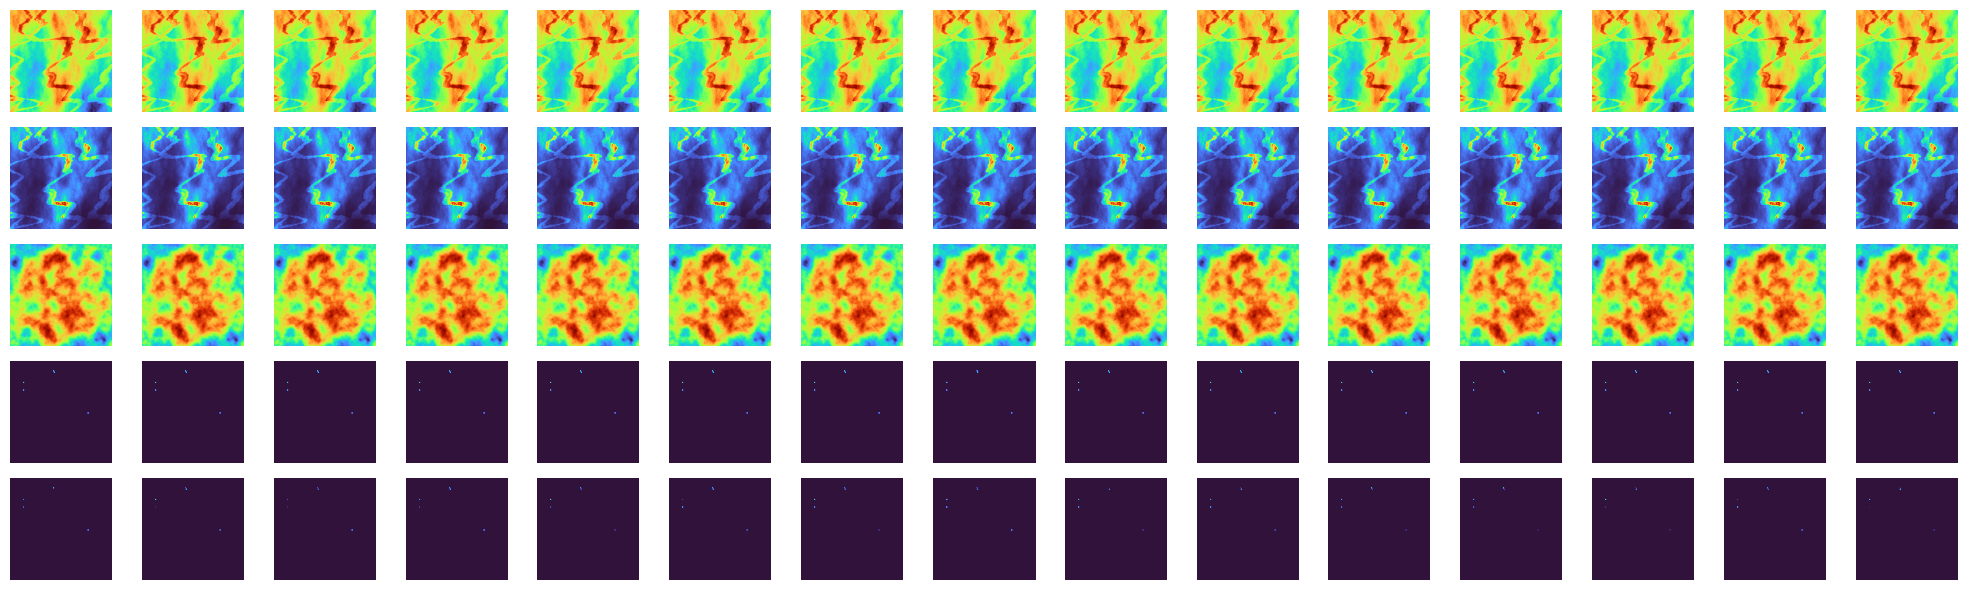

In [244]:
xx = np.load('data/realiation_0.npz')['features']
print(xx.shape)

fig, axs = plt.subplots(5, 15, figsize=(20,6), sharex=True, sharey=True)
for i in range(5):
    for j in range(15):
        ax = axs[i,j]
        ax.imshow(xx[i,:,:,j*2], cmap='turbo')
        ax.axis('off')
plt.tight_layout()
plt.show()

In [8]:
totVol = []
vol = []
freeVol = []
trappedVol = []
leakedVol = []
timesteps = []

for i in tqdm(range(1, 60)):
    d = dd[i]
    totVol.append(d['totVol']/mt2m3)
    vol.append(d['vol']/mt2m3)
    freeVol.append(d['freeVol']/mt2m3)
    trappedVol.append(d['trappedVol']/mt2m3)
    leakedVol.append(d['leakedVol']/mt2m3)
    timesteps.append(d['t'])

totVol = np.array(totVol)
vol = np.array(vol)
freeVol = np.array(freeVol)
trappedVol = np.array(trappedVol)
leakedVol = np.array(leakedVol)
timesteps = np.array(timesteps)

100%|██████████| 59/59 [00:00<00:00, 287414.56it/s]


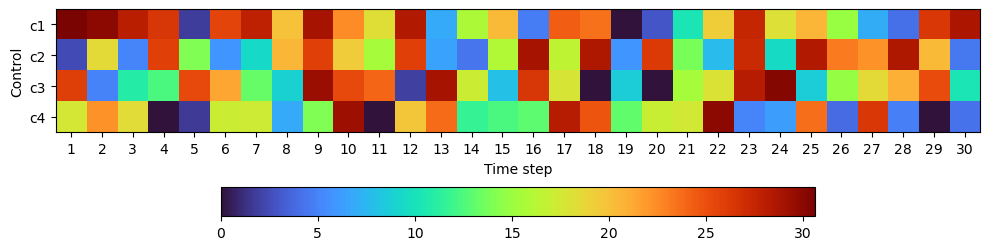

In [9]:
fig = plt.figure(figsize=(10,7))
ax  = fig.add_subplot(111)
im = ax.imshow(cc, cmap='turbo', interpolation='none')
ax.set(yticks=range(cc.shape[0]), yticklabels=['c{}'.format(i) for i in range(1, cc.shape[0]+1)],
       xticks=range(cc.shape[1]), xticklabels=range(1, cc.shape[1]+1),
       xlabel='Time step', ylabel='Control')
plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.084, fraction=0.046)
plt.tight_layout()
plt.show()

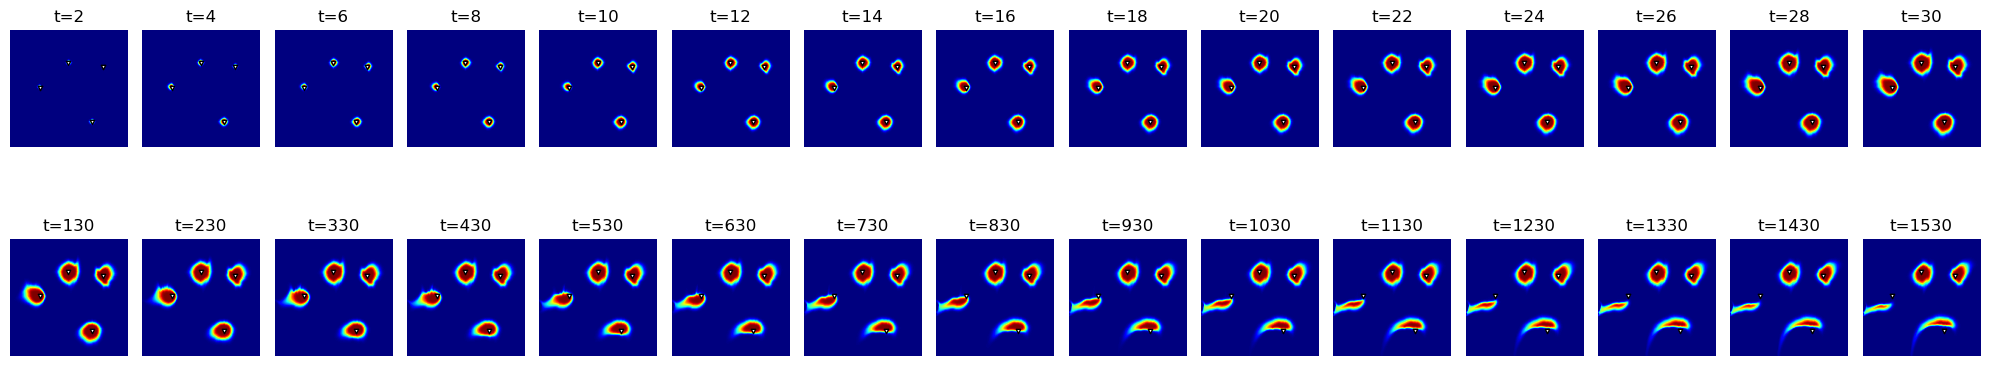

In [10]:
plt.figure(figsize=(20,5))
for i in range(30):
    plt.subplot(2, 15, i+1)
    s = dd[i*2]['s'].reshape(NX,NY) 
    p = dd[i*2]['pressure'].reshape(NX,NY) / psi2pascal
    plt.imshow(s, cmap='jet')
    plt.scatter(ww[:,0], ww[:,1], c='w', edgecolor='k', s=10, marker='v')
    plt.axis('off')
    plt.title('t={}'.format(dd[i*2+1]['t']))
plt.tight_layout()
plt.show()

In [11]:
sat = np.zeros((60, NX, NY))

for i in range(60):
    sat[i] = dd[i]['s'].reshape(NX,NY)

In [67]:
nw = []
for i in tqdm(range(1272)):
    a = sio.loadmat('well_locs/well_locs_{}.mat'.format(i), simplify_cells=True)['var']
    if len(a.shape) == 1:
        a = a.reshape(1, -1)
    nw.append(a.shape[0])

100%|██████████| 1272/1272 [00:01<00:00, 711.12it/s]


In [142]:
pv = np.ones((160,160))*(DX*DY*DZ)

In [143]:
pv @ 

array([[2500000., 2500000., 2500000., ..., 2500000., 2500000., 2500000.],
       [2500000., 2500000., 2500000., ..., 2500000., 2500000., 2500000.],
       [2500000., 2500000., 2500000., ..., 2500000., 2500000., 2500000.],
       ...,
       [2500000., 2500000., 2500000., ..., 2500000., 2500000., 2500000.],
       [2500000., 2500000., 2500000., ..., 2500000., 2500000., 2500000.],
       [2500000., 2500000., 2500000., ..., 2500000., 2500000., 2500000.]])

In [133]:
np.sum(sat[0] @ ) / co2_rho / sec2year * 1e3 * mega

1128595867.4123712

In [131]:
totVol[0]

10226779.697911866

In [141]:
np.max(sat[0])

0.9999999977612406

In [114]:
np.sum( sat[0]) / (DX*NX*DY*NY*DZ*NZ) 

1.9102483009937493e-10

In [104]:
(totVol[1] - totVol[0]) / (DX*DY*DZ)

1.6785524208409772

In [58]:
np.sum(totVol) * co2_rho * sec2year / 1e3 / mega

170778508240.42337

In [17]:
print('Trapped:', np.sum(trappedVol))
print('Leaked:', np.sum(leakedVol))
print('Total:', np.sum(totVol))

Trapped: 623143243.1570532
Leaked: 200003685.0449587
Total: 7882643390.469359


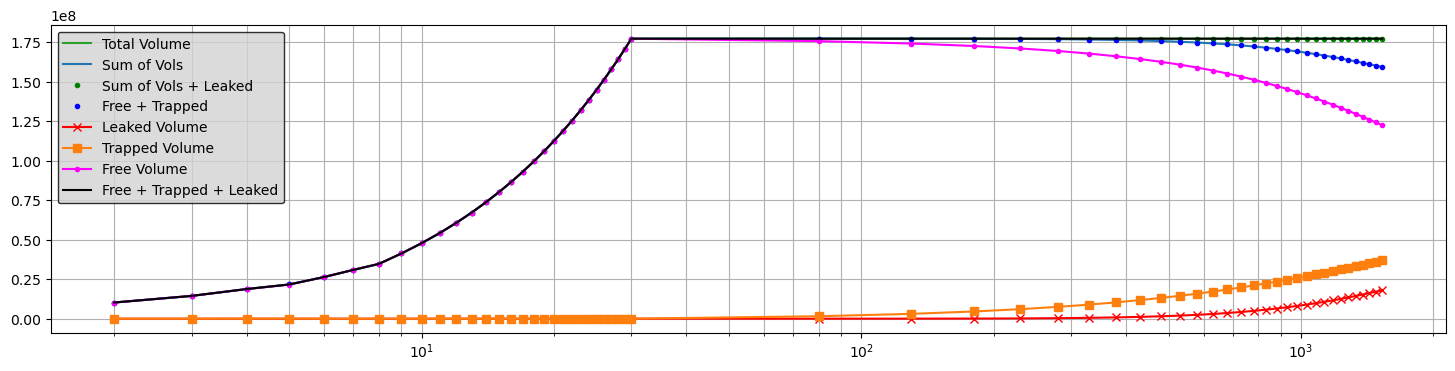

In [12]:
trapped_labels = ['residual (traps)', 'residual', 'free (residual)', 'moveable', 'free plume', 'leaked']

plt.figure(figsize=(18,4))

plt.plot(timesteps, totVol, label='Total Volume', c='tab:green')
plt.plot(timesteps, np.sum(vol, 1), label='Sum of Vols', c='tab:blue')

plt.plot(timesteps, np.sum(vol,1)+leakedVol, label='Sum of Vols + Leaked', ls='', marker='.', c='g')
plt.plot(timesteps, np.sum([freeVol, trappedVol], 0), label='Free + Trapped', ls='', marker='.', c='b')

plt.plot(timesteps, leakedVol, label='Leaked Volume', c='r', marker='x')
plt.plot(timesteps, trappedVol, label='Trapped Volume', c='tab:orange', marker='s')
plt.plot(timesteps, freeVol, label='Free Volume', c='magenta', marker='.')

plt.plot(timesteps, freeVol+trappedVol+leakedVol, c='k', label='Free + Trapped + Leaked')

# vols = np.hstack([vol, leakedVol.reshape(-1,1)])
# for k in range(6):
#     plt.plot(timesteps, vols[:,k], label=trapped_labels[k], ls='-.', c='C{}'.format(k+4))

plt.legend(facecolor='lightgrey', edgecolor='k', loc='upper left')
plt.xscale('log')
plt.grid(True, which='both')

plt.show()

In [13]:
from utils import LpLoss, NeuralOperator